In [24]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex']=True
import scipy
from scipy import interpolate
import scipy.integrate as si
import pandas as pd
from astropy.io import fits
from pylab import imshow,cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import pyfits


In [25]:
c=3e5; h=0.7; H0=100.*h
print H0/c

0.000233333333333


In [26]:
hdulist = pyfits.open('DATA_ALL.fits')
data = hdulist[1].data
print data['HIra'].size

17513


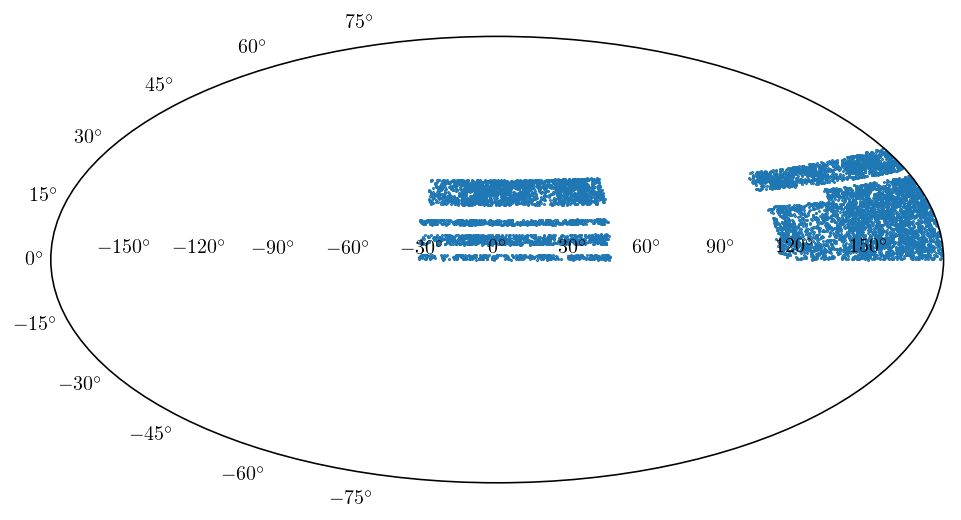

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter((data['HIra'])*np.pi/180., data['HIdec']*np.pi/180., marker='.', s = 1)

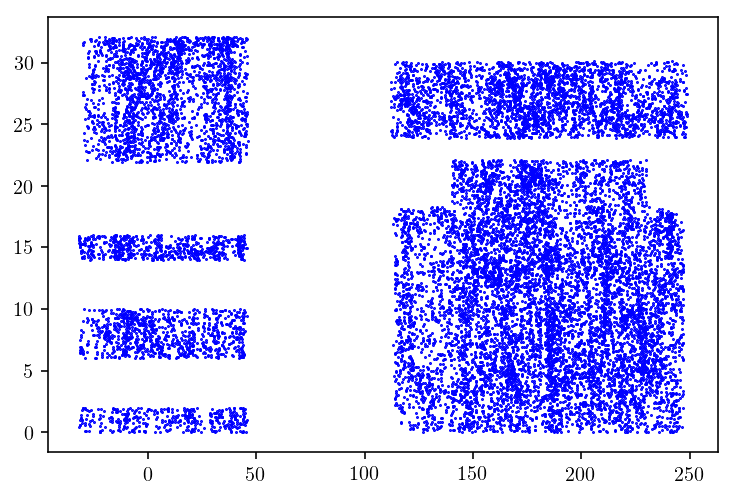

In [28]:
ax = plt.gca()
ax.scatter((data['HIra']), data['HIdec'], marker='.', s=1, color='b')

-2000.2 17912.4


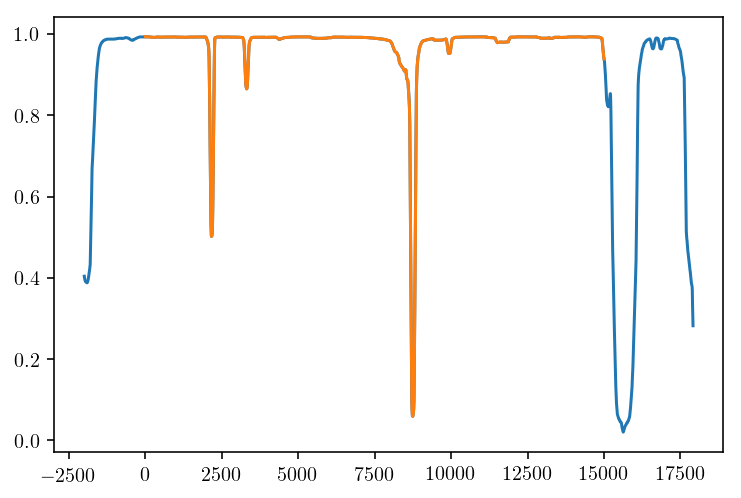

In [29]:
vhrfi,complrfi = np.loadtxt('../rfi_completeness.txt',unpack=True, delimiter=',')
plt.plot(vhrfi,complrfi)
int_complete = scipy.interpolate.interp1d(vhrfi, complrfi, kind='linear')
plt.plot(np.arange(0,15000,0.1),int_complete(np.arange(0,15000,0.1)))
print vhrfi.min(), vhrfi.max()

In [30]:
v_odot = np.array([357.76694557, -76.12567255, 46.33947044])

In [31]:
DATA_theta = 90.-data['HIdec']
DATA_phi   = data['HIra']
print DATA_theta[0]
print DATA_phi[0]
print data['v21'][0], data['vcmb'][0]

62.653055
-29.84375
12737.0 12406.4228193


In [32]:
# Let's check the relation (vh,vcmb,v_odot) for one galaxy:
x=np.sin(DATA_theta[5]*np.pi/180.)*np.cos(DATA_phi[5]*np.pi/180.)
y=np.sin(DATA_theta[5]*np.pi/180.)*np.sin(DATA_phi[5]*np.pi/180.)
z=np.cos(DATA_theta[5]*np.pi/180.)
print np.sum(np.array([x,y,z])*v_odot)
print data['v21'][5] - data['vcmb'][5]
# print hdulist[1].header

337.152565281
337.152565283


In [33]:
rsel, sel_func = np.loadtxt('../selection_function.mass_threshold_7_5.txt', unpack=True)

# old one to compare
old_Sel_func = pd.read_csv('../../sel_func_a40_mhithresh7.5.csv',sep=',')
old_rsel = old_Sel_func[list(['dist/Mpc'])].values
old_sel_func = old_Sel_func[list(['sel_func'])].values

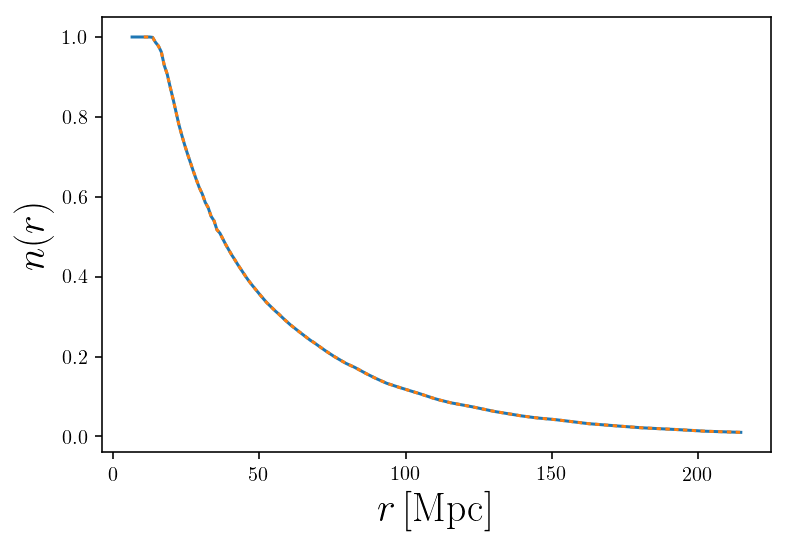

In [34]:
plt.plot(rsel,sel_func)
plt.plot(old_rsel,old_sel_func,':')
plt.xlabel('$r\,[\\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$n(r)$',fontsize=20)
# they the same...

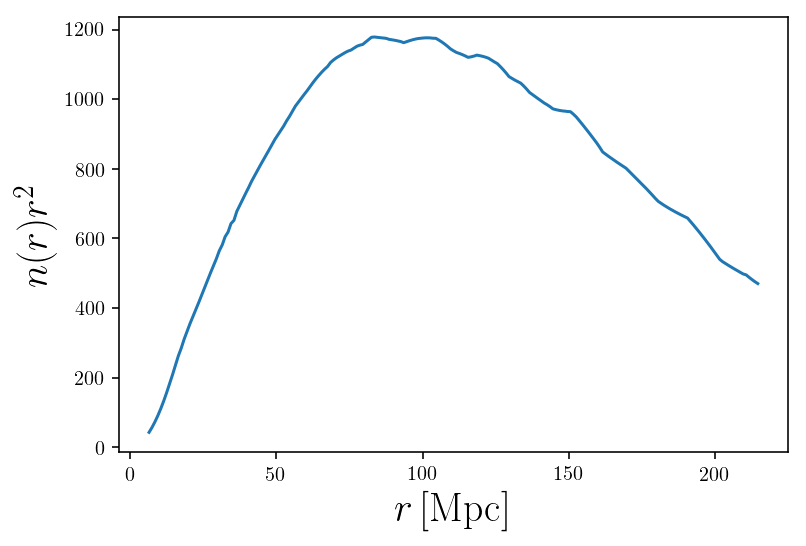

In [65]:
plt.plot(rsel,sel_func*rsel**2)
plt.xlabel('$r\,[\\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$n(r)r^2$',fontsize=20)

In [36]:
print (sel_func*rsel**2).sum(), np.cumsum(sel_func*rsel**2)[-1]

176732.214474 176732.214475


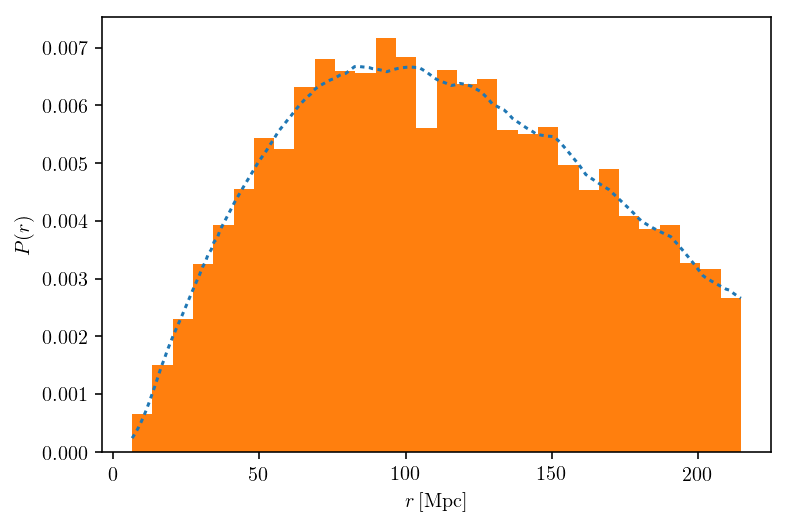

In [37]:
trial = np.random.choice(rsel,size=10000,p=(sel_func*rsel**2)/(sel_func*rsel**2).sum())
plt.plot(rsel,(sel_func*rsel**2)/(sel_func*rsel**2).sum(),':')
plt.hist(trial, bins=30, normed=True)
plt.xlabel('$r\,[\\mathrm{Mpc}]$')
plt.ylabel('$P(r)$')

In [38]:
Np  = 5000000

random_array = np.random.rand(Np,4)

phi = 2.*np.pi*random_array[:,0]-100.*np.pi/180.
theta = np.arccos(-1.+2.*random_array[:,1])

x, y, z = np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)

sel_funcf=interpolate.interp1d(rsel,sel_func,bounds_error=False,fill_value=0)
rsel_os=rsel[0]+(rsel[-1]-rsel[0])*np.arange(10000)/2047.
sel_func_os=sel_funcf(rsel_os)

r = np.random.choice(rsel_os,size=Np,p=(sel_func_os*rsel_os**2)/(sel_func_os*rsel_os**2).sum())
vcmb = r*H0

vhel = vcmb + np.dot(np.array([x,y,z]).T,v_odot)
print vhel.min(), vhel.max()
print np.where((vcmb<700)|(vcmb>15000))[0].size
print np.where((vcmb>700)&(vcmb<15000))[0].size

87.365031207 15376.9425584
10983
4989017


In [39]:
completeness_indices = np.where(int_complete(vhel)>random_array[:,3])[0]
vnewhel = vhel[completeness_indices]
vnewcmb = vcmb[completeness_indices]
phinew  = phi[completeness_indices]
thetanew= theta[completeness_indices]

455.0 701.056886515


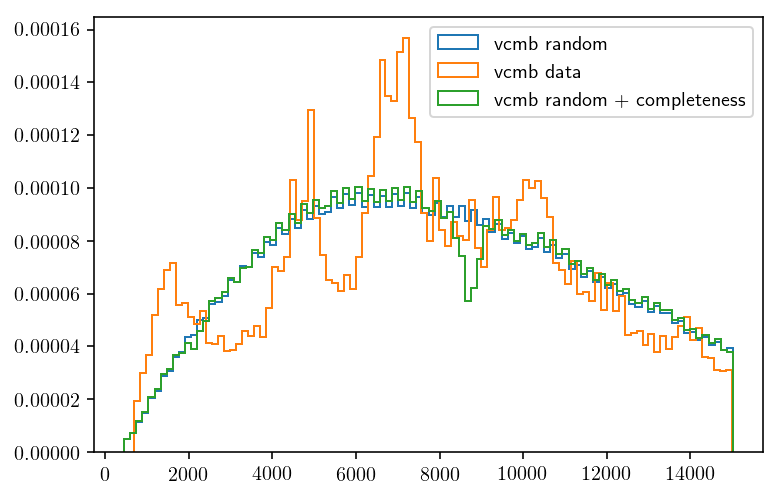

In [40]:
print vcmb.min(), data['vcmb'].min()
plt.hist(vcmb, normed=True, histtype='step', bins=100, label = 'vcmb random')
plt.hist(data['vcmb'],normed=True,histtype='step', bins=100, label = 'vcmb data')
plt.hist(vnewcmb, normed=True, histtype='step', bins=100, label = 'vcmb random + completeness')
plt.legend(loc=0)

In [41]:
rRA = phinew*180./np.pi
rdec= 90.- thetanew*180./np.pi

# cuts in RA and DEC
# BOX1
print np.where((rdec>21.9) & (rdec<=32.1) & (((rRA>=0.1) & (rRA<=46))|((rRA>=329.) & (rRA<=359))))[0].size*1./len(thetanew)

# BOX2
print np.where((rdec>23.9) & (rdec<=30.1) & (rRA>=112.1) & (rRA<=249))[0].size*1./len(thetanew)

# BOX3
print np.where((rdec>0.) & (rdec<18.3) & ((rRA>=113.) & (rRA<=247)))[0].size*1./len(thetanew)

# BOX4
print np.where((rdec>=18.3) & (rdec<=22.1) & ((rRA>=140) & (rRA<=230)))[0].size*1./len(thetanew)

# BOX3s
print np.where(((rRA>=0.1) & (rRA<=46)) & \
                                (((rdec>0) & (rdec<=2.)) | \
                                ((rdec>6) & (rdec<=10.))| \
                                ((rdec>14) & (rdec<=16.)))\
                                )[0].size*1./len(thetanew)

# # ALL together:
window_indices = np.where(((rdec>21.9) & (rdec<=32.1) & ((rRA>=-30) & (rRA<=46)))\
                         | ((rdec>23.9) & (rdec<=30.1) & (rRA>=112.1) & (rRA<=249)) \
                         | ((rdec>0.) & (rdec<18.3) & (rRA>=113.) & (rRA<=247)) \
                         | ((rdec>=18.3) & (rdec<=22.1) & (rRA>=140) & (rRA<=230))\
                         | ((rRA>=-32) & (rRA<=46)) & \
                                (((rdec>0) & (rdec<=2.)) | \
                                ((rdec>6) & (rdec<=10.))| \
                                ((rdec>14) & (rdec<=16.))))[0]
print len(window_indices)*1./len(thetanew)

0.0100675219098
0.0183546112461
0.058488726575
0.00785730129009
0.0088481040735
0.116481845427


In [42]:
0.116*4.*np.pi*(180./np.pi)**2

4785.343504932636

In [43]:
allrRA = rRA[window_indices]
allrdec= rdec[window_indices]

allvnewcmb = vnewcmb[window_indices]
allvnewhel = vnewhel[window_indices]
allphinew  = phinew[window_indices]
allthetanew= thetanew[window_indices]

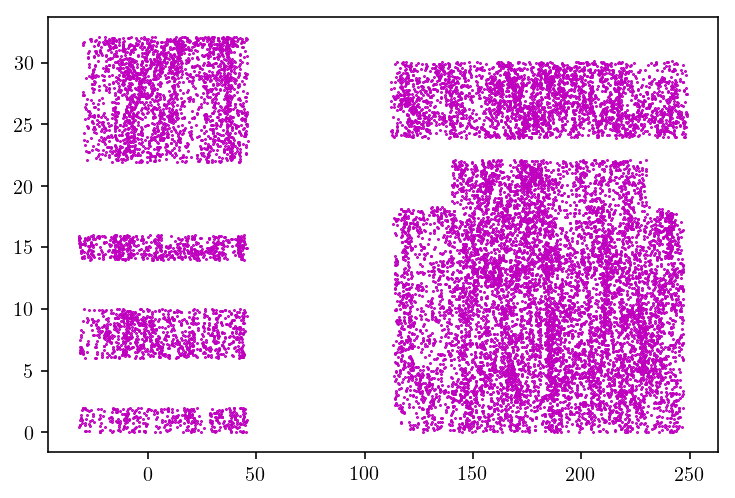

In [44]:
ax = plt.gca()
ax.scatter((data['HIra']), data['HIdec'], marker='.', s=1, color='m')

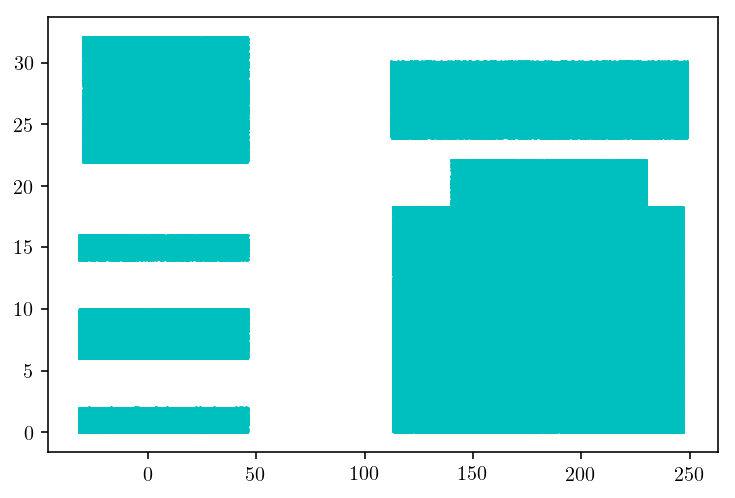

In [45]:
ax = plt.gca()
ax.scatter(allrRA, allrdec, marker='.', s=1, color='c')

In [46]:
len(allphinew), len(data['vcmb'])

(564538, 17513)

In [47]:
print (data['vcmb']/c).min(), (data['vcmb']/c).max(), 1./299792.458*100

0.00233685628838 0.049993961009 0.000333564095198


(array([  1.85956296,   3.92898828,   6.60610199,   9.16824762,
         11.21212448,  11.55520381,  14.29983845,  17.15944116,
         19.23616604,  20.20335777,  22.28373243,  23.67977332,
         25.0028186 ,  25.99920857,  27.15071419,  27.92811736,
         27.69453143,  28.72376942,  29.05407452,  29.66723758,
         28.86063617,  29.28766045,  29.29131023,  29.33145781,
         28.36791586,  27.97738939,  26.83135844,  25.20903118,
         13.50418639,  25.86234182,  26.41163372,  25.18348272,
         24.35498264,  23.71444623,  24.37870621,  23.12683163,
         22.02824782,  20.97711115,  20.03546788,  19.41865504,
         19.01535434,  17.94961855,  17.17221539,  16.5462781 ,
         16.22692234,  15.10461496,  13.88376352,  13.07351233,
         12.7669308 ,  11.91470715]),
 array([ 0.00151667,  0.00248733,  0.003458  ,  0.00442867,  0.00539933,
         0.00637   ,  0.00734067,  0.00831133,  0.009282  ,  0.01025267,
         0.01122333,  0.012194  ,  0.01316467,  

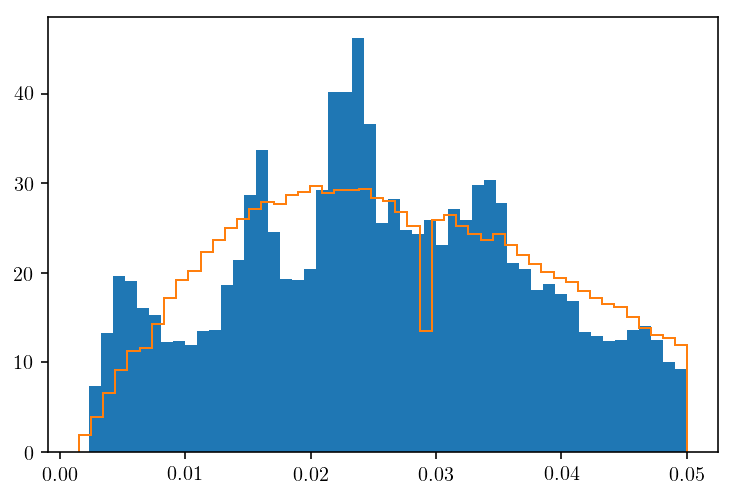

In [48]:
z_d = data['vcmb']/c
z_r = allvnewcmb/c
plt.hist(z_d, normed=True,bins=50)
plt.hist(z_r,histtype='step', normed=True,bins=50)

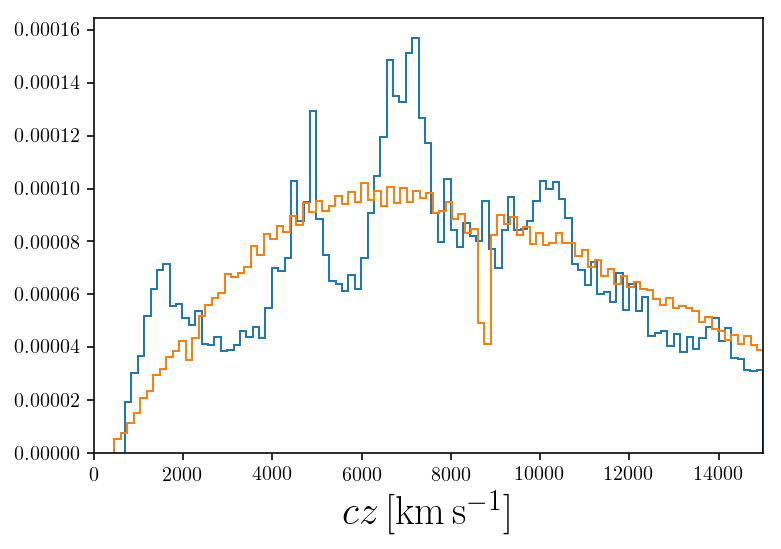

In [49]:
plt.hist(c*z_d, normed=True, bins=100, label = '${\rm Data}$', histtype='step')
plt.hist(c*z_r, normed=True, bins=100, label = '${\rm Random}$', histtype='step')
plt.xlim(0,15000)
plt.xlabel('$cz\,[{\\rm km\,s^{-1}}]$', fontsize=20)
plt.savefig('Redshift_distribution_DATA_RANDOM.pdf', bbox_inches = 'tight')

In [50]:
c*z_d

array([ 12406.42281926,   5539.38181655,   3180.8403148 , ...,
        10778.1093427 ,   8304.31300602,  14368.43839474])

In [51]:
print z_d.min(), z_d.max()
print z_r.min(), z_r.max()
print z_d.shape
print z_d[z_d>0.0025].shape
print z_r.shape

0.00233685628838 0.049993961009
0.00151666666667 0.05005
(17513,)
(17499,)
(564538,)


[ 0.00498759  0.01028905  0.01559051  0.02089197  0.02619343  0.03149489
  0.03679635  0.04209781  0.04739927]
0.00498758649459 0.00233685628838 0.00763831670079
1401
0.010289046907 0.00763831670079 0.0129397771132
1209
0.0155905073194 0.0129397771132 0.0182412375256
2310
0.0208919677318 0.0182412375256 0.023542697938
2779
0.0261934281442 0.023542697938 0.0288441583504
2836
0.0314948885566 0.0288441583504 0.0341456187628
2459
0.036796348969 0.0341456187628 0.0394470791752
2069
0.0420978093814 0.0394470791752 0.0447485395876
1359
0.0473992697938 0.0447485395876 0.05005
1090


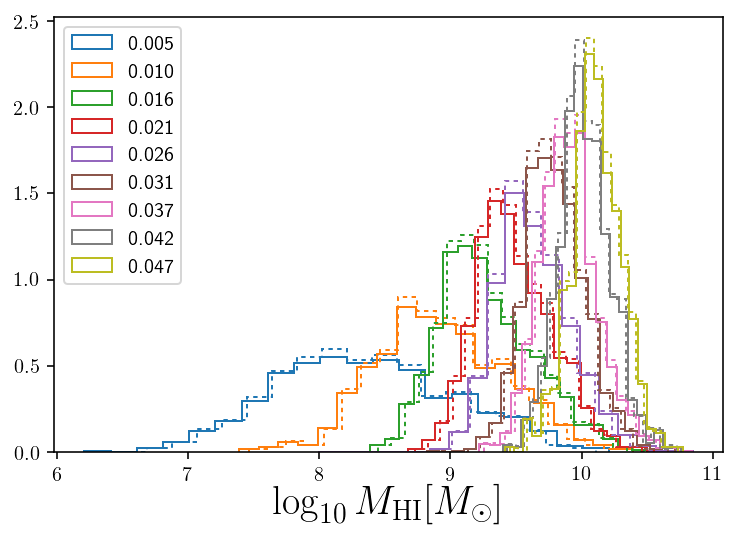

In [52]:
z_bins = np.linspace(z_d.min(),z_r.max(),10)
z_b_c = (z_bins[1:]+z_bins[:-1])/2
print z_b_c
w_random = np.ones_like(z_r)
delta_zbc = np.diff(z_b_c)[0]
for i in xrange(0,z_b_c.size):
    print z_b_c[i], z_bins[i], z_bins[i+1]
    hist, bins = np.histogram(data['loghimass'][np.where((z_d>z_bins[i])&(z_d<=z_bins[i+1]))], bins=20)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / float(cdf[-1])
    random_index = np.where((z_r>z_bins[i])&(z_r<=z_bins[i+1]))[0]
    values = np.random.rand(random_index.size)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    w_random[random_index] = random_from_cdf
    print sum(hist)
    plt.hist(data['loghimass'][np.where((z_d>z_bins[i])&(z_d<=z_bins[i+1]))], \
             bins=20,normed=True,color='C'+str(i),histtype='step', label='%.3f'%z_b_c[i])
    plt.hist(random_from_cdf, bins=20,normed=True,color='C'+str(i), histtype='step',linestyle='dotted')
plt.legend(loc=0)
plt.xlabel('$\log_{10}M_\\mathrm{HI}[M_\\odot]$', fontsize=20)
# plt.savefig('MHI_distribution_DATA_RANDOM.pdf', bbox_inches = 'tight')

In [63]:
print np.where(w_random<=7.1)[0].size
print np.where(data['loghimass']<7.1)[0].size
print data['loghimass'].size-1228

1228
35
16285


0.0013810585512


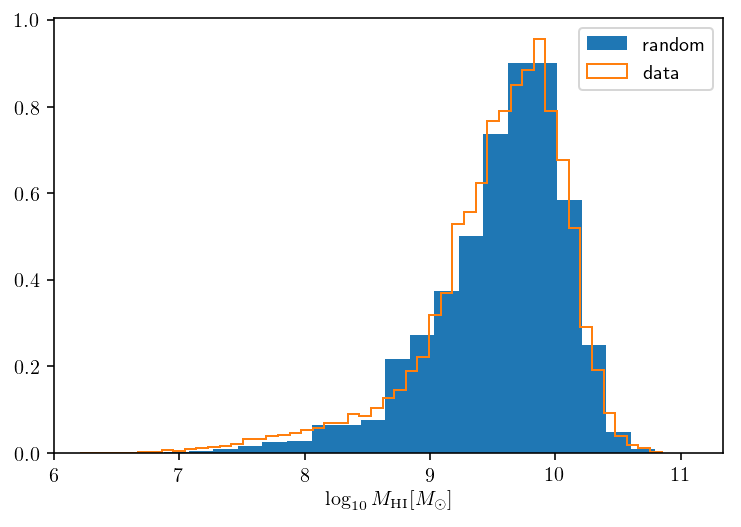

In [42]:
plt.hist(w_random, bins=50,normed=True, label ='random')
plt.hist(data['loghimass'],bins=50,normed=True, label = 'data', histtype='step')
plt.legend(loc=0)
print len(np.where(w_random<1.1)[0])*1./len(w_random)
plt.xlim(6)
plt.xlabel('$\log_{10}M_\\mathrm{HI}[M_\\odot]$')

array([  3.26707169,   5.11635754,  13.00664388,  14.97921546,
        13.68471536,  14.36278684,  11.89707236,  12.26692954,
        12.08200095,  13.86964395,  14.05457253,  19.23257294,
        22.00650173,  29.46528803,  34.64328844,  25.21193055,
        19.91064442,  19.7873587 ,  20.95857308,  30.14335951,
        41.36236039,  41.36236039,  47.52664659,  37.66378867,
        26.32150207,  29.033788  ,  25.458502  ,  25.02700197,
        26.62971638,  23.79414473,  27.92421648,  26.62971638,
        30.63650241,  31.25293103,  28.60228796,  21.69828742,
        20.95857308,  18.61614432,  19.2942158 ,  18.18464429,
        17.38328708,  13.80800109,  13.31485819,  12.76007243,
        12.82171529,  14.05457253,  14.42442971,  12.82171529,
        10.29435795,   9.55464361])

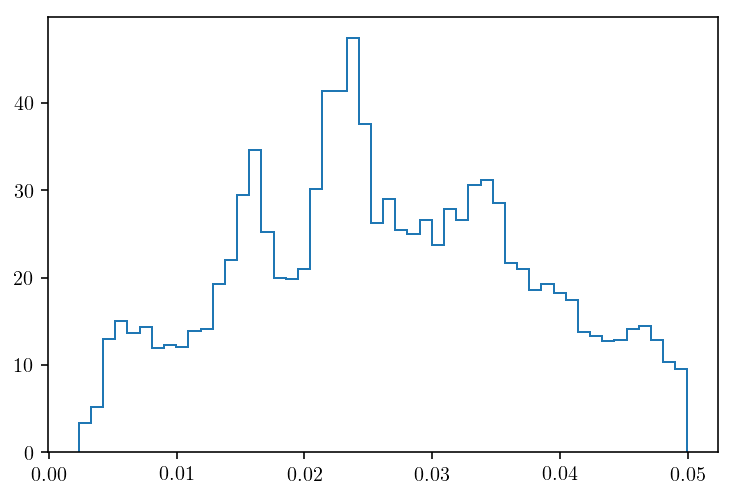

In [52]:
plt.hist(data['vcmb'][data['loghimass']>8]/c,bins=50,normed=True, label = 'data', histtype='step')[0]

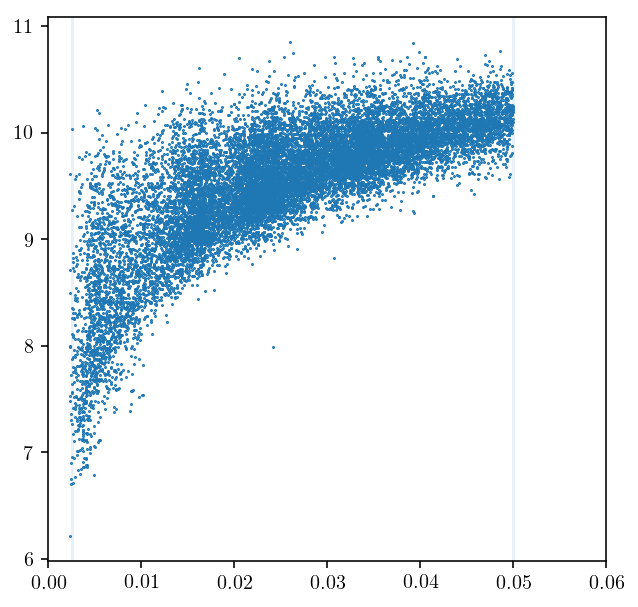

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(data['vcmb']/c,data['loghimass'], '.', markersize=1)
plt.xlim(0,0.06)
# plt.ylim(7,11)
plt.axvline(0.0025, alpha=0.1)
plt.axvline(0.05, alpha=0.1)

(array([  8.07000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.20000000e+01,   0.00000000e+00,   1.10000000e+02,
          2.91000000e+02,   6.45000000e+02,   1.11000000e+03,
          1.80100000e+03,   2.80200000e+03,   2.98200000e+03,
          7.09700000e+03,   7.24600000e+03,   8.32000000e+03,
          2.36030000e+04,   3.05400000e+04,   4.12970000e+04,
          5.59460000e+04,   8.17480000e+04,   9.93420000e+04,
          9.92670000e+04,   6.45470000e+04,   2.70930000e+04,
        

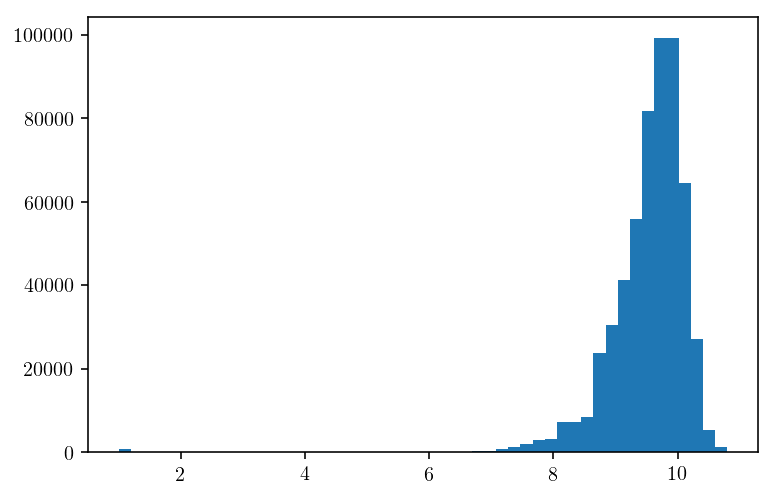

In [54]:
plt.hist(w_random, bins=50)

(7, 11)

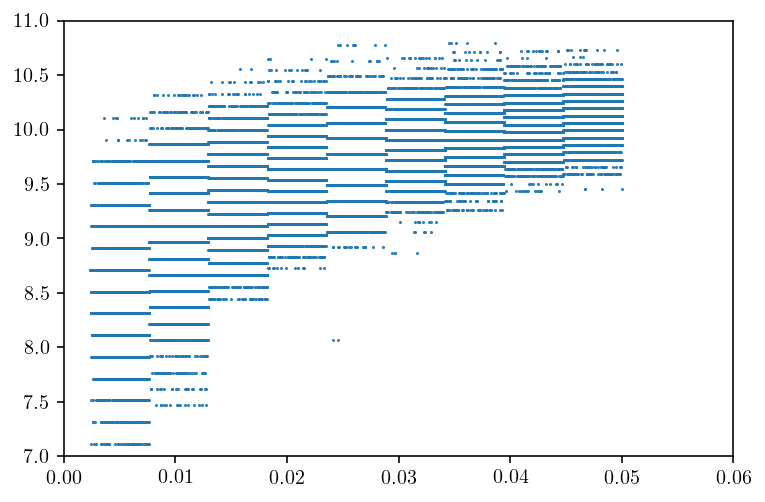

In [55]:
plt.plot(z_r[::10],w_random[::10], '.', markersize=1)
plt.xlim(0,0.06)
plt.ylim(7,11)
# plt.axvline(0.0025, alpha=0.1)
# plt.axvline(0.05, alpha=0.1)

In [56]:
print w_random[0:10]
print data['loghimass'][0:10]

print w_random.min(), w_random.max()
print data['loghimass'].min(), data['loghimass'].max()
print data['vcmb'][data['loghimass']<7.1]/c

[  9.90675   9.2355    8.5565   10.19625   9.62325   9.115     8.665
   9.79125   9.3335    9.3485 ]
[ 9.93  9.82  8.69  9.62  9.92  9.52  9.33  9.47  9.87  8.87]
1.0 10.7995
6.21 10.85
[ 0.00256894  0.00264767  0.00290808  0.0024569   0.00314847  0.00337966
  0.00501987  0.00487281  0.00240411  0.00361083  0.00445145  0.00419414
  0.00244801  0.00533744  0.00353486  0.00373684  0.00449154  0.00405621
  0.00379209  0.00376185  0.00377372  0.00380451  0.00402328  0.00491778
  0.00404875  0.00419951  0.00417101  0.00309016  0.00417344  0.00337249
  0.00450049  0.00309499  0.00235622  0.00319374  0.002769  ]


In [57]:
np.savetxt('random_alpha_ALL_DATA_70_MHI_10bins.txt', np.transpose([allrRA,allrdec,allvnewhel,allvnewcmb,w_random]))

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, projection="aitoff")

ax.scatter(allrRA[w_random>10]*np.pi/180., allrdec[w_random>10]*np.pi/180., marker='.', color='C0', alpha =0.1)
# ax.scatter(fulldata[fulldata['loghimass']>8]['HIra']*np.pi/180., fulldata[fulldata['loghimass']>8]['HIdec']*np.pi/180., marker='.', color='C1', alpha =0.1)